In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from os import listdir
import json
import pvlib
from pvlib.pvsystem import PVSystem, retrieve_sam
from pvlib.location import Location
from pvlib.modelchain import ModelChain
from pvlib.atmosphere import gueymard94_pw

In [2]:
# Importing the dataset
Weather_data_path = 'data/weather/'
solar_data_path = 'data/solar/'

weather_file = [f for f in listdir(Weather_data_path) if f.endswith('.csv')]
solar_file = [f for f in listdir(solar_data_path) if (f.endswith('.csv'))]

weather_data = pd.read_csv(Weather_data_path+weather_file[0])
solar_data = pd.read_csv(solar_data_path + solar_file[0])

In [3]:
weather_data['Timestamp'] = pd.to_datetime(weather_data['Timestamp'].values,utc=True).tz_convert('Asia/Kolkata')
solar_data['Timestamp'] = pd.to_datetime(solar_data['Timestamp'].values, utc=True).tz_convert('Asia/Kolkata')
weather_data.index = weather_data['Timestamp']
solar_data.index = solar_data['Timestamp']
if 'Timestamp' in weather_data.columns:
    weather_data.drop('Timestamp', inplace=True, axis=1)
if 'Timestamp' in solar_data.columns:
    solar_data.drop('Timestamp', inplace=True, axis=1)

### Replacing the null values with Interpolated values

In [4]:
for col in weather_data.columns:
    if weather_data[col].isnull().sum() >0:
        weather_data[col].interpolate(method='time',axis=0, inplace=True)
if sum(weather_data.isnull().sum(axis=0)) == 0:
    print('All Null values removed')

All Null values removed


### Adding a precipitable water column

In [11]:
weather_data['precipitable_water'] = gueymard94_pw(weather_data['temp_air'], weather_data['relative_humidity'])
# This row has relative humidity = 100, which is practically not possible
if len(weather_data.loc[weather_data['precipitable_water'] > 8, 'relative_humidity']) > 0:
    print('Invalid values in the relative humidity column \n Removing such values')
    weather_data.loc['2018-08-19 13:03:00+05:30','relative_humidity'] = 70
    weather_data['precipitable_water'] = gueymard94_pw(weather_data['temp_air'], weather_data['relative_humidity'])

In [12]:
weather_data.head()

,Battery Level,relative_humidity,temp_air,wind_speed,Wind Direction,dew_point,ghi,dhi,atm_qnh,atm_qfe,dni,azimuth,global_E,Diffuse_E,Direct_E,precipitable_water
Timestamp,,,,,,,,,,,,,,,,
2018-05-06 12:46:00+05:30,13.5435,11.53090,41.2083,0.481642,194.469,5.90070,909.660,264.500,1006.04,970.171,673.202,237.250,0.015153,0.004405,0.011201,1.411996
2018-05-06 12:51:00+05:30,13.5484,9.95614,41.9842,3.144320,240.983,4.41924,908.991,267.461,1005.91,970.043,673.282,239.931,0.015158,0.004453,0.011250,1.269299
2018-05-06 12:56:00+05:30,13.5467,9.41877,42.1846,1.600240,180.964,3.80964,890.220,267.483,1005.70,969.843,656.265,242.329,0.014871,0.004459,0.010964,1.213312
2018-05-06 13:01:00+05:30,13.5466,10.04090,41.8025,1.441300,238.379,4.41003,901.187,267.491,1005.70,969.839,673.950,244.478,0.014993,0.004456,0.011183,1.268106
2018-05-06 13:06:00+05:30,13.5512,9.48973,42.1796,1.618480,181.860,3.91016,888.130,273.098,1005.57,969.719,656.922,246.435,0.014824,0.004549,0.010958,1.222136


### Plant Information

- Panel : Vikram Solar Eldora VSP.72.315.03, 16 panels X 315Wp
- Tilt : 25 degree south-facing
- Inverter : Zever Solar
- Capacity : 5kW
- Lats, Longs : 25.1, 75.8
- Elevation  : 249m

In [48]:
with open('data/config.json') as jsonfile:
    data = json.load(jsonfile)
    
lats, longs = data['lats'], data['longs']
tilt = data['tilt']
surf_azi = data['surf_azi'] #since panel faces south
altitude = data['altitude']
name = data['name']
timezone = data['timezone']
albedo = data['albedo']
mod_per_string = data['modules_per_string']
str_per_inv = data['strings_per_inverter']

try:
    panel_model = retrieve_sam('CECMod')
    panel_model = panel_model[data['module']]
except:
    try:
        panel_model = retrieve_sam('SandiaMod')
        panel_model = panel_model[data['module']]
    except:
        print('Module not found in the database!!')
try:    
    inverter_model = retrieve_sam('CECinverter')
    inverter_model = inverter_model[data['inverter']]
except:
    try:
        inverter_model = retrieve_sam('SandiaInverter')
        inverter_model = inverter_model[data['inverter']]
    except:
        print('Inverter model not found in the database!!')

### Plotting Function

In [62]:
def plot_results(output, save_fig=False, model='High-level'):
    
    # Power calculated from the power plant data
    Power_orig_ac = solar_data['Pac']
    Power_orig_dc = solar_data['Vpv1']*solar_data['Ipv1']
        
    Power_pred = output['i_sc']*output['v_oc']
    print('Maximum Predicted Power = ',Power_pred.max(axis=0),'\n')
    print('\nPower Plots\n')
    plt.figure(figsize=[10,6])
    plt.subplot(311)
    output.v_oc[0:1500].plot(grid=True, label='Predicted')
    solar_data.Vpv1[0:1500].plot(grid=True, label='Original')
    plt.title('Voltage')
    plt.legend()
    # plt.savefig(fname='predictions_voltage')
    
    plt.subplot(312)
    output.i_sc[0:1500].plot(grid=True, label='Predicted')
    solar_data.Ipv1[0:1500].plot(grid=True, label='Original')
    plt.title('Current')
    plt.legend()
    # plt.savefig(fname='predictions_current')
    
    plt.subplot(313)
    Power_pred[0:1500].plot(grid=True, label='Predicted_dc')
    Power_orig_dc[0:1500].plot(grid=True, label='Original_dc')
    Power_orig_ac[0:1500].plot(grid=True, label='Original_ac')
    plt.title('Power')
    plt.legend()
    # plt.savefig(fname='predictions_power')
    plt.show()
    print('\n\nDistribution of Values\n')
    Power_pred.hist(figsize = [10,3],bins=20)

### Building the Model - Model Using High Level APIs

In [22]:
# Using the high level API

location = Location(latitude=lats, longitude=longs, altitude=altitude)
system = PVSystem(surface_tilt = tilt, surface_azimuth=surf_azi, albedo=albedo, 
                  module_parameters=panel_model, inverter_parameters=inverter_model,
                 modules_per_string=mod_per_string, strings_per_inverter=str_per_inv, name=name)
mc = ModelChain(system, location, aoi_model='no_loss', name=name+'_ModelChain')

In [56]:
mc.run_model(times = weather_data.index, weather = weather_data)
output_hl = mc.dc

C:\Users\coola\Anaconda3\envs\test\lib\site-packages\pvlib\singlediode.py:418: RuntimeWarning: invalid value encountered in greater
  idx_p = 0. < Gsh
C:\Users\coola\Anaconda3\envs\test\lib\site-packages\pvlib\tools.py:411: RuntimeWarning: invalid value encountered in greater
  df['SW_Flag'] = df['f1'] > df['f2']
C:\Users\coola\Anaconda3\envs\test\lib\site-packages\pvlib\tools.py:418: RuntimeWarning: invalid value encountered in greater
  errflag = (abs(err) > .01).any()


Maximum Predicted Power =  7070.012182584113 


Power Plots



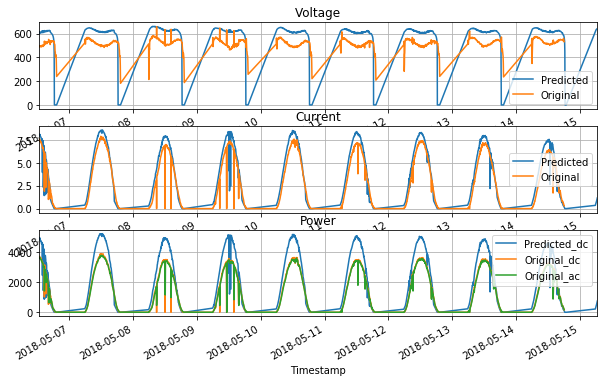



Distribution of Values



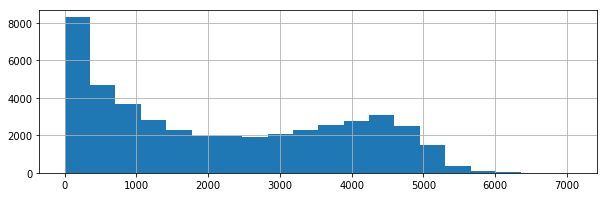

In [63]:
plot_results(output_hl)

### Building the Model - Model Using functions

In [35]:
times = weather_data.index
solpos = pvlib.solarposition.get_solarposition(times, lats, longs)
solpos['azimuth'] = weather_data['azimuth']
dni_extra = pvlib.irradiance.get_extra_radiation(times)
airmass = pvlib.atmosphere.get_relative_airmass(solpos['apparent_zenith'])
pressure = pvlib.atmosphere.alt2pres(altitude)
am_abs = pvlib.atmosphere.get_absolute_airmass(airmass, pressure)
tl = pvlib.clearsky.lookup_linke_turbidity(times, lats, longs)
cs = pvlib.clearsky.ineichen(solpos['apparent_zenith'], am_abs, tl,
                             dni_extra=dni_extra, altitude=altitude)
aoi = pvlib.irradiance.aoi(tilt, surf_azi, solpos['apparent_zenith'], solpos['azimuth'])
total_irrad = pvlib.irradiance.get_total_irradiance(tilt, surf_azi,
                                                    solpos['apparent_zenith'], solpos['azimuth'],
                                                    cs['dni'], cs['ghi'], cs['dhi'],
                                                    dni_extra=dni_extra, model='haydavies')
spectral_modifier = system.first_solar_spectral_loss(weather_data['precipitable_water'], airmass.values)
fd = 1
aoi_modifier = system.ashraeiam(aoi.values)
effective_irradiance = spectral_modifier*(total_irrad['poa_direct']*aoi_modifier+fd*total_irrad['poa_diffuse'])
temps = system.sapm_celltemp(total_irrad['poa_global'], weather_data['wind_speed'], weather_data['temp_air'])
effective_irradiance = weather_data['dni']
(photocurrent, saturation_current, resistance_series,resistance_shunt, nNsVth) = system.calcparams_cec(effective_irradiance,
                                       temps['temp_cell'])
diode_params = (photocurrent, saturation_current,resistance_series,resistance_shunt, nNsVth)
output_fl = system.singlediode(photocurrent, saturation_current, resistance_series,resistance_shunt, nNsVth)
output_fl = system.scale_voltage_current_power(output_fl)

Maximum Predicted Power =  5524.906348715974 


Power Plots



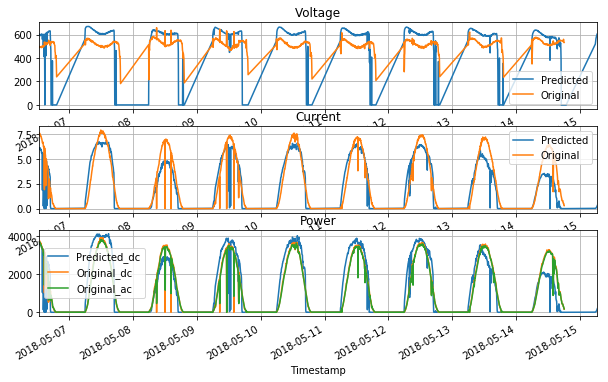



Distribution of Values



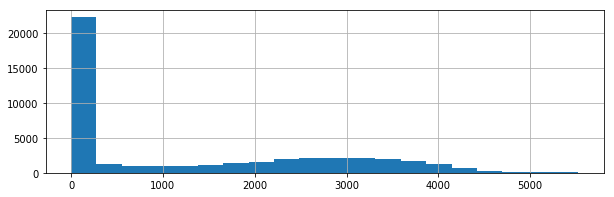

In [64]:
plot_results(output_fl, False, 'Function_level')